In [2]:
#prepares all the packages needed
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV


from sklearn import svm
from sklearn import tree
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8","#ffff33","#4daf4a","#ff7f00"])

/Users/CJL/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [61]:
#Loads integrated data, defines X dataframe for modeling
sent=pd.read_csv('org_data/XLV_technicals.csv',index_col=0)
tryt=sent[['Price','7','50','200','bull_bear_msg_ratio','bull_minus_bear','CMF [20]','MACD (12,26,9) - MACD','Williams %R [14]']]
X=tryt[tryt['Price'] > 0]
Xi=sent[sent['Price'] > 0][['Price','7','50','200','750g','50200g','7200g','750d','50200d','7200d','bull_bear_msg_ratio','bull_minus_bear']]
Xt=sent[sent['Price'] > 0][['Price','CMF [20]','MACD (12,26,9) - MACD','Williams %R [14]']]

In [62]:
#function to create categorical variable, based on thresholds
def tester(row):
    if row['Price'] > row['PS'] * 1.007:
        return 1
    elif row['Price'] < row['PS'] * .993:
        return -1
    else:
        return 0


In [63]:
#creates new categorical variable based on shift (how many days out to predict)
X['PS']=X['Price'].shift(1)

X['Move']=X.apply(tester,axis=1)

del X['PS']

/Users/CJL/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/CJL/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [64]:
#separates the full dataset into constituent parts
alls=X
y=X['Move']
del alls['Move']
allsent=alls[['Price','7','50','200','bull_bear_msg_ratio','bull_minus_bear']]
ratio= alls[['Price','7','50','200','bull_bear_msg_ratio']]
minus= alls[['Price','7','50','200','bull_minus_bear']]
averages=alls[['Price','bull_bear_msg_ratio','bull_minus_bear']]
price=pd.DataFrame(alls['Price'])
lists=[allsent,ratio,minus,averages,price,Xi,Xt]

In [65]:
#make a module to test all three different modeling paradigms, and pick the max from each parameter space
score=[]

for data in lists:
    test=[]
    XTrain, XTest, yTrain, yTest = train_test_split(data, y, train_size=0.4)
    
    parameters = {'kernel':('linear', 'rbf'), 'C':[.1, 10]}
    svr = svm.SVC()
    clf = GridSearchCV(svr, parameters,cv=5)
    clf.fit(XTrain, yTrain)
    y_pred=clf.predict(XTest)
    test.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
    
    parameters = {'n_neighbors':[1, 20]}
    kNN = KNeighborsClassifier()
    clf = GridSearchCV(kNN, parameters,cv=5)
    clf.fit(XTrain, yTrain)
    y_pred=clf.predict(XTest)
    test.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
   
    parameters = {'max_depth':[1, 20]}
    trees = tree.DecisionTreeClassifier()
    clf = GridSearchCV(trees, parameters,cv=5)
    clf.fit(XTrain, yTrain)
    y_pred=clf.predict(XTest)
    test.append(metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
    
    score.append(test)
   
    
#builds the results into a dataframe for plotting
scores=pd.DataFrame(score,columns=['svm','kNN','tree'],index=['sentiment','ratio','minus','sent only','price','crosses','techs'])
print(scores)

                svm       kNN      tree
sentiment  0.687500  0.590909  0.602273
ratio      0.681818  0.568182  0.613636
minus      0.659091  0.437500  0.403409
sent only  0.562500  0.437500  0.562500
price      0.551136  0.556818  0.551136
crosses    0.625000  0.528409  0.551136
techs      0.500000  0.500000  0.562500


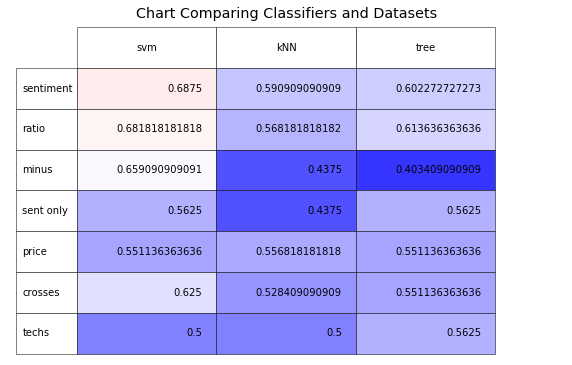

In [66]:
#plots the model tests on a table, colored by accuracy
vals=scores.values
cols=scores.columns
rows=scores.index
fig=plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
the_table = ax.table(cellText=vals,
          colLabels=cols, rowLabels=rows,
          loc='center',cellColours=plt.cm.seismic(vals*.75))
the_table.scale(.75, 3.4)
plt.title('Chart Comparing Classifiers and Datasets')
plt.savefig("XLV_model.pdf")
plt.show()